In [5]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.stats.mstats import winsorize

frame = pd.read_csv('mom1_data_combined_adj_close.csv', index_col=0)
column_filter = [col for col in frame.columns if col >= '1990-01']
frame = frame[column_filter]

# frame
print(frame['1990-01'].max())

# 1. NaN 값을 0으로 채우기
df_filled_zeros = frame.fillna(0)

# 2. Winsorizing 진행
df_winsorized_filled_zeros = df_filled_zeros.apply(lambda x: pd.Series(winsorize(x, limits=[0.01, 0.01]), index=x.index))

# 3. 원래 NaN이었던 곳을 다시 NaN으로 만들기
df_winsorized_final = df_winsorized_filled_zeros.where(frame.notna())

# 최종 winsorized 데이터의 '1990-01' 열에서의 최대값 확인
final_max_value = df_winsorized_final['1990-01'].max()
print(final_max_value)

1.6666666666666663
0.0931174089068826


In [7]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import copy

def investment_strategy(return_data_frame, number_of_clusters ,threshold, batch=64, bins=32, hidden=128):
    cluster_dir = f'../res/predictions/{number_of_clusters}_characteristics_us_batch_{batch}_bins_{bins}_hidden_{hidden}'
    cluster_results = glob(cluster_dir + '/*')
    cluster_results.sort()

    all_months = return_data_frame.columns

    cumulative_return = 0
    cumulative_returns_list = []
    log_returns_list = []

    for idx, current_month in enumerate(tqdm(all_months)):
        # 원본 데이터 복사
        copy_dataframe = copy.deepcopy(return_data_frame)

        assert str(cluster_results[idx].split('/')[-1].split('.')[0]) == str(current_month), '월이 일치하지 않음'

        # 다음 달 
        next_month = all_months[idx+1] if idx+1 < len(all_months) else None
        if next_month is None:
            continue
        
        cluster_data = pd.read_csv(cluster_results[idx], index_col=0)
        cluster_data.sort_values(by='mom1', ascending=False, inplace=True)
        cluster_data['position'] = 0 #* 포지션 초기화 -> Long: 1, Short: -1, No position: 0 

        # 스프레드 계산
        for _, group in cluster_data.groupby('clusters'):
            returns_asc = group.sort_values(by='mom1', ascending=True)['mom1']
            returns_desc = group.sort_values(by='mom1', ascending=False)['mom1']
            spread_vec = returns_desc.values - returns_asc.values

            group['spread'] = spread_vec
            spread_std = group['spread'].std()

            # 표준편차 기반 투자 결정
            in_portfolio = group['spread'].abs() > spread_std * threshold
            Long_or_Short = (-group['spread'] / (group['spread'].abs())) #* Long: 1, Short: -1
            cluster_data.loc[group.index, 'position'] = in_portfolio * Long_or_Short #
        
        cluster_data['position'].fillna(0, inplace=True)
        # Long 포지션 수익률 반영
        long_positions = cluster_data[cluster_data['position'] == 1]
        copy_dataframe.loc[long_positions.index, next_month] *= 1

        # Short 포지션 수익률 반영 (음수로 만들어 숏매매 수익률 반영)
        short_positions = cluster_data[cluster_data['position'] == -1]
        copy_dataframe.loc[short_positions.index, next_month] *= -1

        # 보유하지 않은 자산은 수익률 0
        no_position = cluster_data[cluster_data['position'] == 0]
        copy_dataframe.loc[no_position.index, next_month] = np.nan


        # 다음 달의 평균 수익률 계산
        next_month_returns = copy_dataframe[next_month].dropna()
        average_return_next_month = next_month_returns[next_month_returns!=0].mean()
        
        log_return = np.log(1 + average_return_next_month)
        log_returns_list.append(log_return)
        # 누적 로그 수익률 업데이트 및 누적 수익률 계산
        cumulative_return = np.exp(np.log(1 + cumulative_return) + log_return) - 1
        cumulative_returns_list.append(cumulative_return)

    print("포트폴리오 수익률: ", cumulative_return)    
    return cumulative_return, cumulative_returns_list, log_returns_list

#cumulative_return_10, cumulative_returns_list_10, log_returns_list_10 = investment_strategy(df_winsorized_final, number_of_clusters=10, threshold=2)
#cumulative_return_20, cumulative_returns_list_20, log_returns_list_20 = investment_strategy(df_winsorized_final, number_of_clusters=20, threshold=2)
#cumulative_return_30, cumulative_returns_list_30, log_returns_list_30 = investment_strategy(df_winsorized_final, number_of_clusters=30, threshold=2)
#cumulative_return_50, cumulative_returns_list_50, log_returns_list_50 = investment_strategy(df_winsorized_final, number_of_clusters=50, threshold=2)
#cumulative_return_100, cumulative_returns_list_100, log_returns_list_100 = investment_strategy(df_winsorized_final, number_of_clusters=100, threshold=2)

In [47]:
cumulative_return_1, cumulative_returns_list_1, log_returns_list_1 = investment_strategy(
    df_winsorized_final, number_of_clusters=10, threshold=1.5, batch=32, bins=64, hidden=128)
cumulative_return_2, cumulative_returns_list_2, log_returns_list_2 = investment_strategy(
    df_winsorized_final, number_of_clusters=10, threshold=1.8, batch=32, bins=64, hidden=128)
cumulative_return_3, cumulative_returns_list_3, log_returns_list_3 = investment_strategy(
    df_winsorized_final, number_of_clusters=10, threshold=2.0, batch=32, bins=64, hidden=128)
cumulative_return_4, cumulative_returns_list_4, log_returns_list_4 = investment_strategy(
    df_winsorized_final, number_of_clusters=10, threshold=2.3, batch=32, bins=64, hidden=128)

  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  40.358984938392844


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  54.43425919161121


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  64.76522961289761


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  56.58280681524782


In [48]:
cumulative_return_5, cumulative_returns_list_5, log_returns_list_5 = investment_strategy(
    df_winsorized_final, number_of_clusters=10, threshold=2.5, batch=32, bins=64, hidden=128)
cumulative_return_6, cumulative_returns_list_6, log_returns_list_6 = investment_strategy(
    df_winsorized_final, number_of_clusters=10, threshold=2.8, batch=32, bins=64, hidden=128)

  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  50.65506312950019


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  49.99255569661331


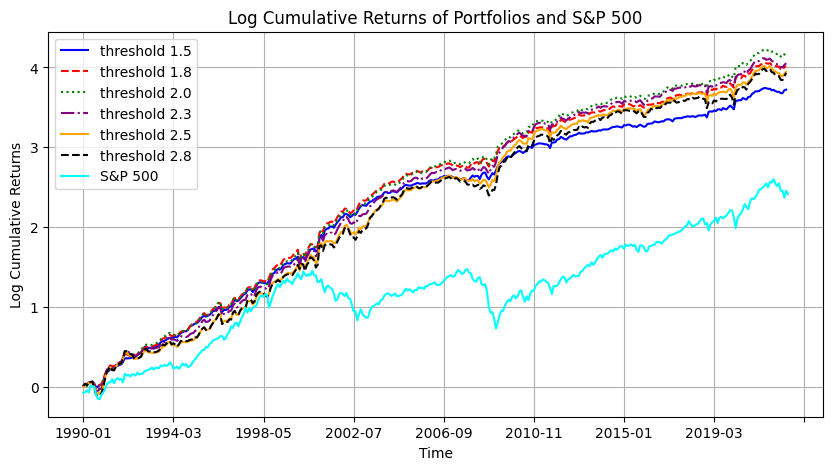

In [8]:
import matplotlib.pyplot as plt
# 데이터 로드
sp = pd.read_csv('sp500_pre.csv', index_col=0)

# 그래프 설정
plt.figure(figsize=(10, 5))

# 라인 플롯
plt.plot(np.log(np.array(cumulative_returns_list_1)+1), label='threshold 1.5', color='blue', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_2)+1), label='threshold 1.8', color='red', linestyle='dashed')
plt.plot(np.log(np.array(cumulative_returns_list_3)+1), label='threshold 2.0', color='green', linestyle='dotted')
plt.plot(np.log(np.array(cumulative_returns_list_4)+1), label='threshold 2.3', color='purple', linestyle='dashdot')
plt.plot(np.log(np.array(cumulative_returns_list_5)+1), label='threshold 2.5', color='orange', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_6)+1), label='threshold 2.8', color='black', linestyle='dashed')
np.log((sp['Monthly Returns']+1).cumprod()).plot(label='S&P 500', color='cyan', linestyle='solid')

# 레전드
plt.legend()

# 축 레이블
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')

# 타이틀
plt.title('Log Cumulative Returns of Portfolios and S&P 500')

# 그리드
plt.grid(True)

# 그래프 표시
plt.show()

In [80]:

# Load Model
from universal_approximator import Simple_QNetwork
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm.auto import tqdm

network = Simple_QNetwork(state_size=4, hidden_sizes=[32,32], action_size=6)
network.load_state_dict(torch.load('../res/q_learning_threshold/models/model_test_501-best.pt'))
network.train()
network.cuda()
# Load S&P Data
sp = pd.read_csv('sp500.csv', index_col=0)

# thresholds
thresholds = [1.5, 1.8, 2.0, 2.3, 2.5, 2.8]

q_actions = []

# Iterate over months
for month in sp.iterrows():
    state = torch.FloatTensor(month[1].values).cuda()
    with torch.no_grad():
        action = network(state).argmax().item()
    q_actions.append(thresholds[action])

    
def investment_strategy_dqn(return_data_frame, number_of_clusters, q_network_actions, batch=32, bins=64, hidden=128):
    cluster_dir = f'../res/predictions/{number_of_clusters}_characteristics_us_batch_{batch}_bins_{bins}_hidden_{hidden}'
    cluster_results = glob(cluster_dir + '/*')
    cluster_results.sort()

    all_months = return_data_frame.columns

    cumulative_return = 0
    cumulative_returns_list = []
    log_returns_list = []

    for idx, current_month in enumerate(tqdm(all_months)):
        # 현재 상태에 따른 threshold 값을 Q-network로부터 받아옴
        threshold = q_network_actions[idx]
        copy_dataframe = copy.deepcopy(return_data_frame)

        assert str(cluster_results[idx].split('/')[-1].split('.')[0]) == str(current_month), '월이 일치하지 않음'

        # 다음 달 
        next_month = all_months[idx+1] if idx+1 < len(all_months) else None
        if next_month is None:
            continue
        
        cluster_data = pd.read_csv(cluster_results[idx], index_col=0)
        cluster_data.sort_values(by='mom1', ascending=False, inplace=True)
        cluster_data['position'] = 0 #* 포지션 초기화 -> Long: 1, Short: -1, No position: 0 

        # 스프레드 계산
        for _, group in cluster_data.groupby('clusters'):
            returns_asc = group.sort_values(by='mom1', ascending=True)['mom1']
            returns_desc = group.sort_values(by='mom1', ascending=False)['mom1']
            spread_vec = returns_desc.values - returns_asc.values

            group['spread'] = spread_vec
            spread_std = group['spread'].std()

            # 표준편차 기반 투자 결정
            in_portfolio = group['spread'].abs() > spread_std * threshold
            Long_or_Short = (-group['spread'] / (group['spread'].abs())) #* Long: 1, Short: -1
            cluster_data.loc[group.index, 'position'] = in_portfolio * Long_or_Short #
        
        cluster_data['position'].fillna(0, inplace=True)
        # Long 포지션 수익률 반영
        long_positions = cluster_data[cluster_data['position'] == 1]
        copy_dataframe.loc[long_positions.index, next_month] *= 1

        # Short 포지션 수익률 반영 (음수로 만들어 숏매매 수익률 반영)
        short_positions = cluster_data[cluster_data['position'] == -1]
        copy_dataframe.loc[short_positions.index, next_month] *= -1

        # 보유하지 않은 자산은 수익률 0
        no_position = cluster_data[cluster_data['position'] == 0]
        copy_dataframe.loc[no_position.index, next_month] = np.nan


        # 다음 달의 평균 수익률 계산
        next_month_returns = copy_dataframe[next_month].dropna()
        average_return_next_month = next_month_returns[next_month_returns!=0].mean()
        
        log_return = np.log(1 + average_return_next_month)
        log_returns_list.append(log_return)
        # 누적 로그 수익률 업데이트 및 누적 수익률 계산
        cumulative_return = np.exp(np.log(1 + cumulative_return) + log_return) - 1
        cumulative_returns_list.append(cumulative_return)

    print("포트폴리오 수익률: ", cumulative_return)    
    return cumulative_return, cumulative_returns_list, log_returns_list

# df_winsorized_final, number_of_clusters=10, threshold=1.5, batch=32, bins=64, hidden=128
# while dqn[0] < 80:
#     dqn = investment_strategy_dqn(df_winsorized_final, number_of_clusters=10, q_network_actions=q_actions, batch=32, bins=64, hidden=128)
#     print(dqn[0])
dqn = investment_strategy_dqn(df_winsorized_final, number_of_clusters=10, q_network_actions=q_actions, batch=32, bins=64, hidden=128)

  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  55.16906067755271


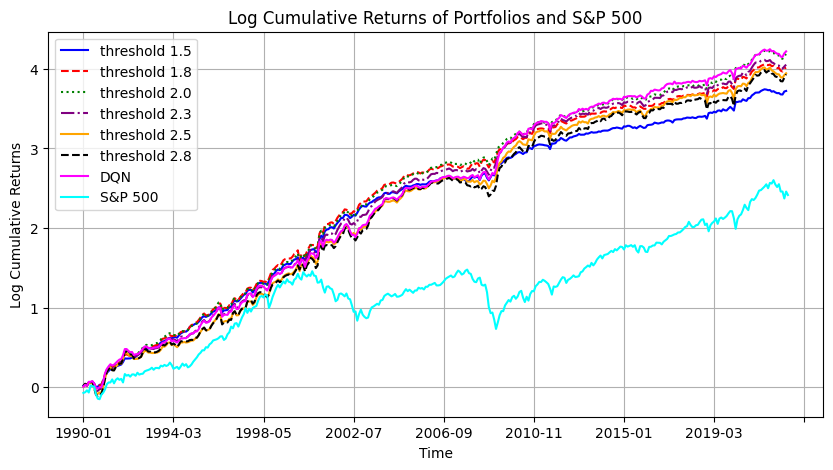

In [65]:
import matplotlib.pyplot as plt
# 데이터 로드
sp = pd.read_csv('sp500_pre.csv', index_col=0)

# 그래프 설정
plt.figure(figsize=(10, 5))

# 라인 플롯
plt.plot(np.log(np.array(cumulative_returns_list_1)+1), label='threshold 1.5', color='blue', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_2)+1), label='threshold 1.8', color='red', linestyle='dashed')
plt.plot(np.log(np.array(cumulative_returns_list_3)+1), label='threshold 2.0', color='green', linestyle='dotted')
plt.plot(np.log(np.array(cumulative_returns_list_4)+1), label='threshold 2.3', color='purple', linestyle='dashdot')
plt.plot(np.log(np.array(cumulative_returns_list_5)+1), label='threshold 2.5', color='orange', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_6)+1), label='threshold 2.8', color='black', linestyle='dashed')
plt.plot(np.log(np.array(dqn[1])+1), label='DQN', color='Magenta', linestyle='solid')
np.log((sp['Monthly Returns']+1).cumprod()).plot(label='S&P 500', color='cyan', linestyle='solid')

# 레전드
plt.legend()

# 축 레이블
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')

# 타이틀
plt.title('Log Cumulative Returns of Portfolios and S&P 500')

# 그리드
plt.grid(True)

# 그래프 표시
plt.show()

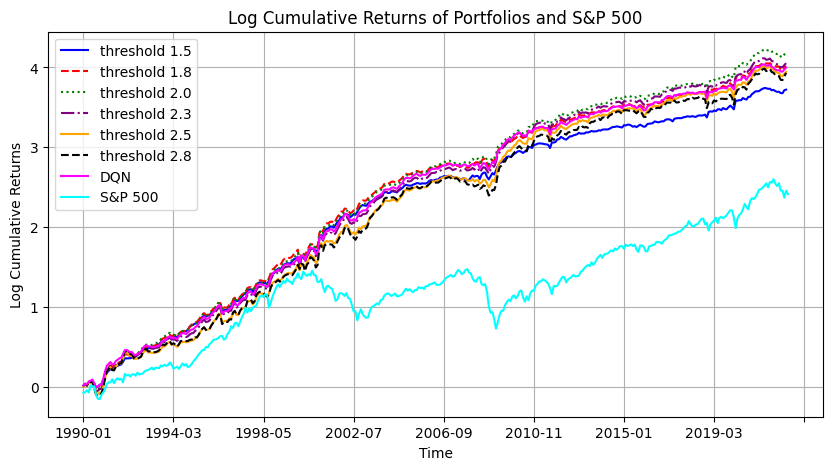

In [50]:
import matplotlib.pyplot as plt
# 데이터 로드
sp = pd.read_csv('sp500_pre.csv', index_col=0)

# 그래프 설정
plt.figure(figsize=(10, 5))

# 라인 플롯
plt.plot(np.log(np.array(cumulative_returns_list_1)+1), label='threshold 1.5', color='blue', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_2)+1), label='threshold 1.8', color='red', linestyle='dashed')
plt.plot(np.log(np.array(cumulative_returns_list_3)+1), label='threshold 2.0', color='green', linestyle='dotted')
plt.plot(np.log(np.array(cumulative_returns_list_4)+1), label='threshold 2.3', color='purple', linestyle='dashdot')
plt.plot(np.log(np.array(cumulative_returns_list_5)+1), label='threshold 2.5', color='orange', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_6)+1), label='threshold 2.8', color='black', linestyle='dashed')
plt.plot(np.log(np.array(dqn[1])+1), label='DQN', color='Magenta', linestyle='solid')
np.log((sp['Monthly Returns']+1).cumprod()).plot(label='S&P 500', color='cyan', linestyle='solid')

# 레전드
plt.legend()

# 축 레이블
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')

# 타이틀
plt.title('Log Cumulative Returns of Portfolios and S&P 500')

# 그리드
plt.grid(True)

# 그래프 표시
plt.show()

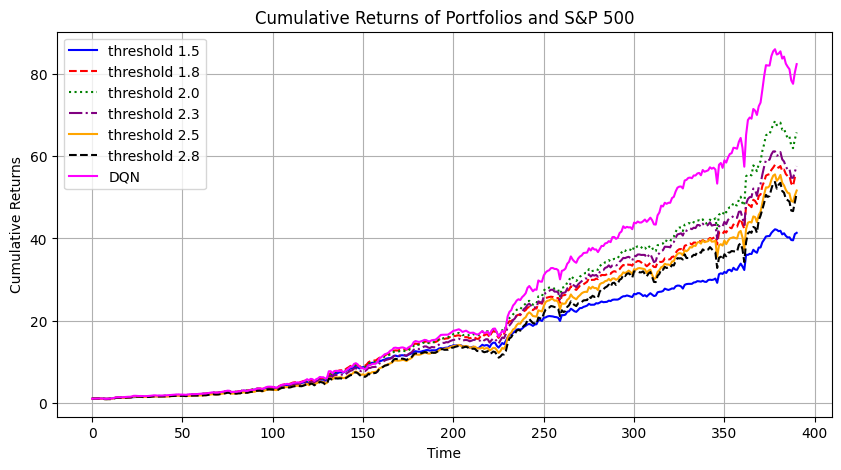

In [46]:
import matplotlib.pyplot as plt
# 데이터 로드
sp = pd.read_csv('sp500_pre.csv', index_col=0)

# 그래프 설정
plt.figure(figsize=(10, 5))

# 라인 플롯
plt.plot((np.array(cumulative_returns_list_1)+1), label='threshold 1.5', color='blue', linestyle='solid')
plt.plot((np.array(cumulative_returns_list_2)+1), label='threshold 1.8', color='red', linestyle='dashed')
plt.plot((np.array(cumulative_returns_list_3)+1), label='threshold 2.0', color='green', linestyle='dotted')
plt.plot((np.array(cumulative_returns_list_4)+1), label='threshold 2.3', color='purple', linestyle='dashdot')
plt.plot((np.array(cumulative_returns_list_5)+1), label='threshold 2.5', color='orange', linestyle='solid')
plt.plot((np.array(cumulative_returns_list_6)+1), label='threshold 2.8', color='black', linestyle='dashed')
plt.plot((np.array(dqn[1])+1), label='DQN', color='Magenta', linestyle='solid')
# 레전드
plt.legend()

# 축 레이블
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')

# 타이틀
plt.title('Cumulative Returns of Portfolios and S&P 500')

# 그리드
plt.grid(True)

# 그래프 표시
plt.show()

# 예전 작업물

In [9]:
cumulative_return_1, cumulative_returns_list_1, log_returns_list_1 = investment_strategy(
    df_winsorized_final, number_of_clusters=10, threshold=2, batch=64)
cumulative_return_2, cumulative_returns_list_2, log_returns_list_2 = investment_strategy(
    df_winsorized_final, number_of_clusters=20, threshold=2, batch=64)
cumulative_return_3, cumulative_returns_list_3, log_returns_list_3 = investment_strategy(
    df_winsorized_final, number_of_clusters=30, threshold=2, batch=64)
cumulative_return_4, cumulative_returns_list_4, log_returns_list_4 = investment_strategy(
    df_winsorized_final, number_of_clusters=50, threshold=2, batch=64)
cumulative_return_5, cumulative_returns_list_5, log_returns_list_5 = investment_strategy(
    df_winsorized_final, number_of_clusters=100, threshold=2, batch=64)


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  54.009539497462306


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  53.363203640587166


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  59.01743772157441


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  56.16824357475506


  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  50.863155597820715


<Axes: xlabel='Date'>

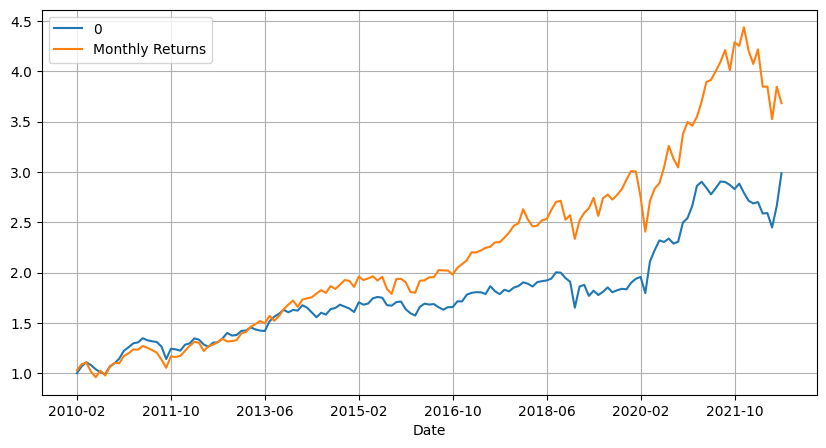

In [95]:
invest = pd.DataFrame(np.array(cumulative_returns_list_8)+1,index=sp.index[1:])
invest_2010 = invest.loc['2010-01-01':]
# make invest_2010 start from 0
sp_2010 = sp.loc['2010-01-01':]
invest_2010 = invest_2010/invest_2010.iloc[0]
invest_2010.plot(figsize=(10,5), grid=True, legend=True)
                    (sp_2010['Monthly Returns']+1).cumprod().plot(grid=True, legend=True)

<Axes: xlabel='Date'>

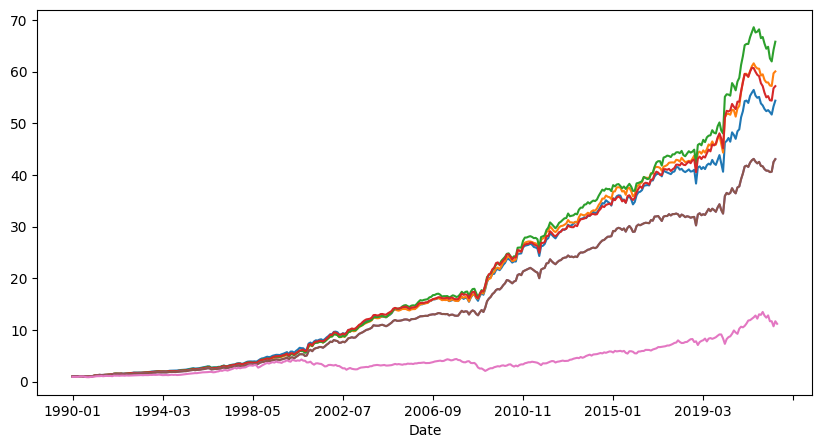

In [25]:
import matplotlib.pyplot as plt
sp = pd.read_csv('sp500.csv', index_col=0)
plt.figure(figsize=(10, 5))
plt.plot((np.array(cumulative_returns_list_1)+1))
#plt.plot((np.array(cumulative_returns_list_2)+1))
plt.plot((np.array(cumulative_returns_list_3)+1))
#plt.plot((np.array(cumulative_returns_list_4)+1))
plt.plot((np.array(cumulative_returns_list_44)+1))
plt.plot((np.array(cumulative_returns_list_5)+1))
#plt.plot((np.array(cumulative_returns_list_6)+1))
plt.plot((np.array(cumulative_returns_list_7)+1))
plt.plot((np.array(cumulative_returns_list_8)+1))
(sp['Monthly Returns']+1).cumprod().plot()

In [13]:
sp = pd.read_csv('sp500.csv', index_col=0)

<Axes: xlabel='Date'>

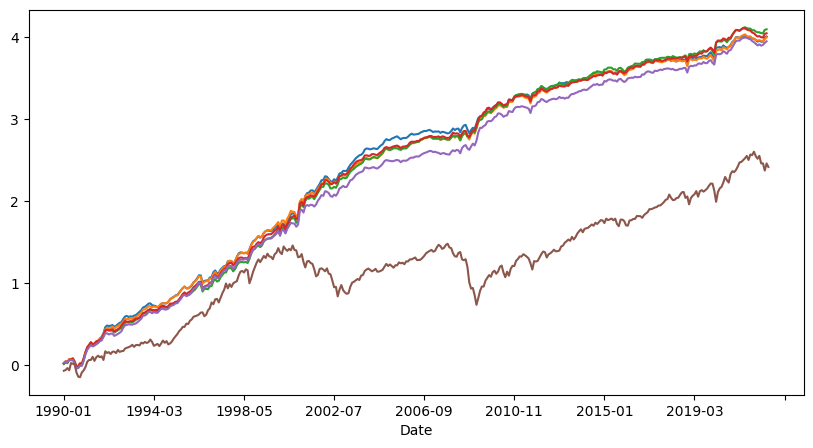

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(np.log(np.array(cumulative_returns_list_10)+1))
plt.plot(np.log(np.array(cumulative_returns_list_20)+1))
plt.plot(np.log(np.array(cumulative_returns_list_30)+1))
plt.plot(np.log(np.array(cumulative_returns_list_50)+1))
plt.plot(np.log(np.array(cumulative_returns_list_100)+1))
np.log((sp['Monthly Returns']+1).cumprod()).plot()

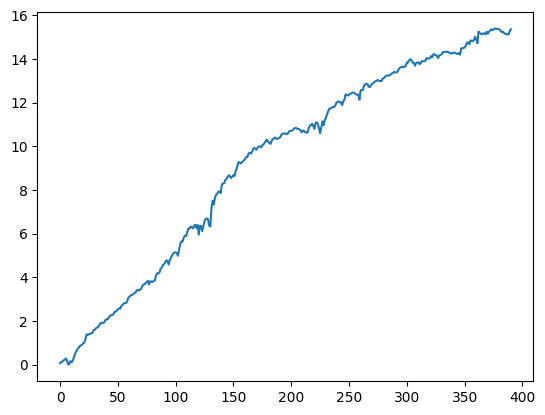

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.log(np.array(cumulative_returns_list_10)+1))

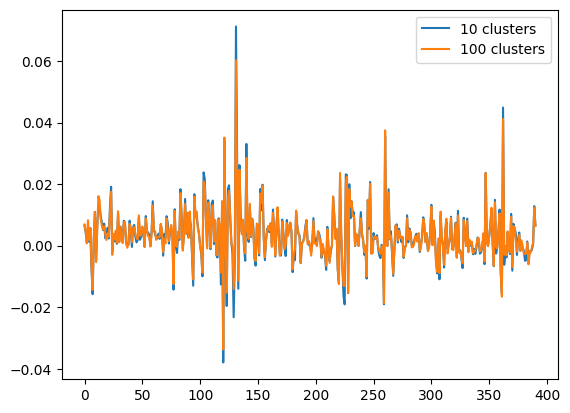

In [26]:
plt.plot(log_returns_list_10, label='10 clusters')
plt.plot(log_returns_list_100, label='100 clusters')
plt.legend()

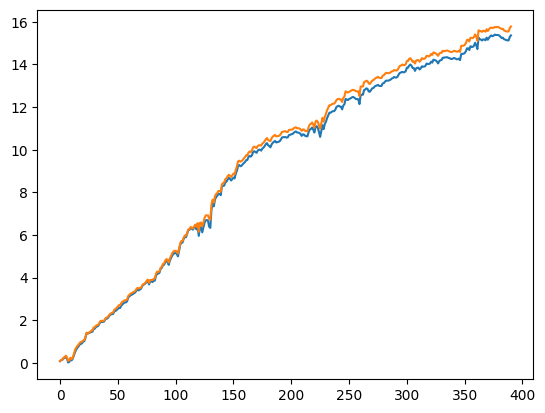

In [28]:
import matplotlib.pyplot as plt
plt.plot(np.log(np.array(cumulative_returns_list_10)+1))
plt.plot(np.log(np.array(cumulative_returns_list_100)+1))

In [7]:
cumulative_return, cumulative_returns_list, log_returns_list = investment_strategy(df_winsorized_final, threshold=1)

  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  0.5733600118430648


In [8]:
cumulative_return, cumulative_returns_list, log_returns_list = investment_strategy(df_winsorized_final, threshold=2)

  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  0.1904554879300273


In [9]:
cumulative_return, cumulative_returns_list, log_returns_list = investment_strategy(df_winsorized_final, threshold=3)

  0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  0.08512957510438901


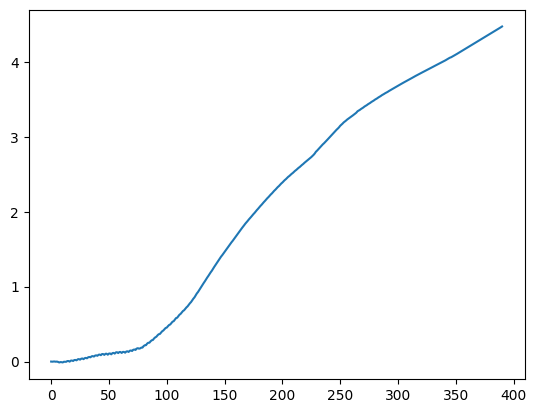

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.log(np.array(cumulative_returns_list)+1))

In [61]:
def investment_modified(threshold):

    cluster_dir = '../res/predictions/50_characteristics_us_batch_64_bins_32_hidden_128'
    cluster_results = glob(cluster_dir + '/*')
    cluster_results.sort()
    
    all_month = df_winsorized_final.columns
    copy_frame = df_winsorized_final.copy()
    
    cum_value = 0
    cum_list = []
    log_list = []
    
    for idx, month in enumerate(tqdm(all_month)):
        next_month = all_month[idx+1] if idx+1 < len(all_month) else None
        if next_month is None:
            break

        cluster_frame = pd.read_csv(cluster_results[idx], index_col=0)

        month_std = cluster_frame['mom1'].std() # * 모 표준편차? 
        diff_ = []
        for _, group in cluster_frame.groupby('clusters'):
            group_sorted = group.sort_values(by='mom1')

            temp_long_ = group_sorted.iloc[:int(len(group_sorted) / 2)]
            temp_short_ = group_sorted.iloc[-int(len(group_sorted) / 2):]

            for j in range(len(temp_long_)):
                diff = np.log(1 + (temp_short_.iloc[-(j + 1)]['mom1']) - (temp_long_.iloc[j]['mom1']))
                diff_.append(diff)

        for _, group in cluster_frame.groupby('clusters'):
            group_sorted = group.sort_values(by='mom1')

            temp_long = group_sorted.iloc[:int(len(group_sorted) / 2)]
            temp_short = group_sorted.iloc[-int(len(group_sorted) / 2):]

            for j in range(len(temp_long)):
                diff = np.log(1 + (np.exp(temp_short.iloc[-(j + 1)]['mom1']) - np.exp(temp_long.iloc[j]['mom1'])))
                if diff > diff_cut:
                    copy_frame.loc[temp_long.index[j], next_month] *= 1
                    copy_frame.loc[temp_short.index[-(j + 1)], next_month] *= -1

        earning = copy_frame[next_month].dropna().mean()
        log_return = np.log(1 + earning)
        log_list.append(log_return)
        
        cum_value = np.exp(np.log(1 + cum_value) + log_return) - 1
        cum_list.append(cum_value)

    print("portfolio return: ", cum_value)    
    return cum_value, cum_list, log_list

cum_value, cum_list, log_list = investment_modified(0.05)


  0%|          | 0/392 [00:00<?, ?it/s]

KeyboardInterrupt: 

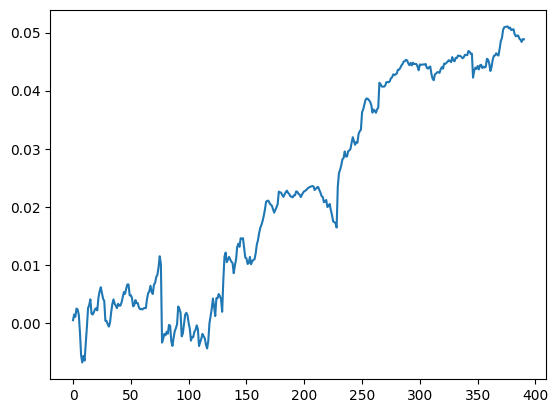

In [40]:
import matplotlib.pyplot as plt
plt.plot(np.log(np.array(cum_list)+1))

In [43]:
def investment_modified(threshold):

    all_month = df_winsorized_final.columns
    copy_frame = df_winsorized_final.copy()
    
    cum_value = 0
    cum_list = []
    log_list = []
    
    for idx, month in enumerate(tqdm(all_month)):
        next_month = all_month[idx+1] if idx+1 < len(all_month) else None
        if next_month is None:
            break

        cluster_frame = pd.read_csv(cluster_results[idx], index_col=0)
        diff_ = []
        for _, group in cluster_frame.groupby('clusters'):
            group_sorted = group.sort_values(by='mom1')

            temp_long_ = group_sorted.iloc[:int(len(group_sorted) / 2)]
            temp_short_ = group_sorted.iloc[-int(len(group_sorted) / 2):]

            for j in range(len(temp_long_)):
                diff = np.log(1 + (np.exp(temp_short_.iloc[-(j + 1)]['mom1']) - np.exp(temp_long_.iloc[j]['mom1'])))
                diff_.append(diff)

        if len(diff_) > 0:
            diff_cut = np.std(diff_)
            if diff_cut > threshold:
                for _, group in cluster_frame.groupby('clusters'):
                    group_sorted = group.sort_values(by='mom1')

                    temp_long = group_sorted.iloc[:int(len(group_sorted) / 2)]
                    temp_short = group_sorted.iloc[-int(len(group_sorted) / 2):]

                    for j in range(len(temp_long)):
                        diff = np.log(1 + (np.exp(temp_short.iloc[-(j + 1)]['mom1']) - np.exp(temp_long.iloc[j]['mom1'])))
                        if diff > diff_cut:
                            copy_frame.loc[temp_long.index[j], next_month] *= 1
                            copy_frame.loc[temp_short.index[-(j + 1)], next_month] *= -1

        earning = copy_frame[next_month].dropna().mean()
        log_return = np.log(1 + earning)
        log_list.append(log_return)
        
        cum_value = np.exp(np.log(1 + cum_value) + log_return) - 1
        cum_list.append(cum_value)

    print("portfolio return: ", cum_value)    
    return cum_value, cum_list, log_list

cum_value, cum_list, log_list = investment_modified(2)


  0%|          | 0/392 [00:00<?, ?it/s]

portfolio return:  4.654657554727514


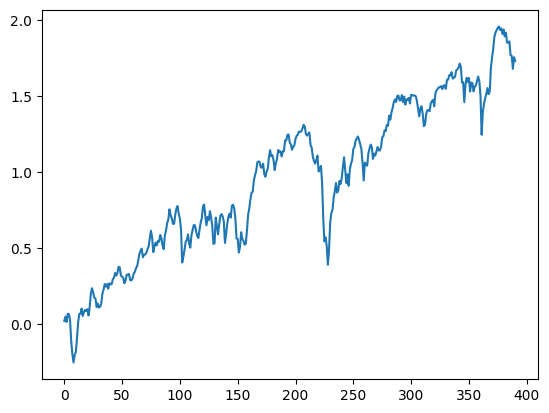

In [44]:
import matplotlib.pyplot as plt
plt.plot(np.log(np.array(cum_list)+1))